# Single Camera

In [1]:
import torch
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import tqdm.notebook as tqdm
from IPython import display
from sklearn.model_selection import train_test_split
import custom_utils
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True

aircraft-detection custom utils


In [2]:
model = custom_utils.mlp().to(device)

In [3]:
with open('processed_data\\1.pkl', 'rb') as f:
    detections, distances, calibration = pkl.load(f)
pred, gt = custom_utils.convert_to_model_format(detections, distances, calibration, scale_pred = model.scale_pred, scale_gt = model.scale_gt, skip_missing = False)

In [4]:
# select data 1
pred = pred[:, 4:]

In [5]:
mask = np.logical_not(np.all((pred == 0), axis = 1))
pred = pred[mask]
gt = gt[mask]

Text(0.5, 0.98, 'Aircraft Distance vs Predictors (Mono Camera)')

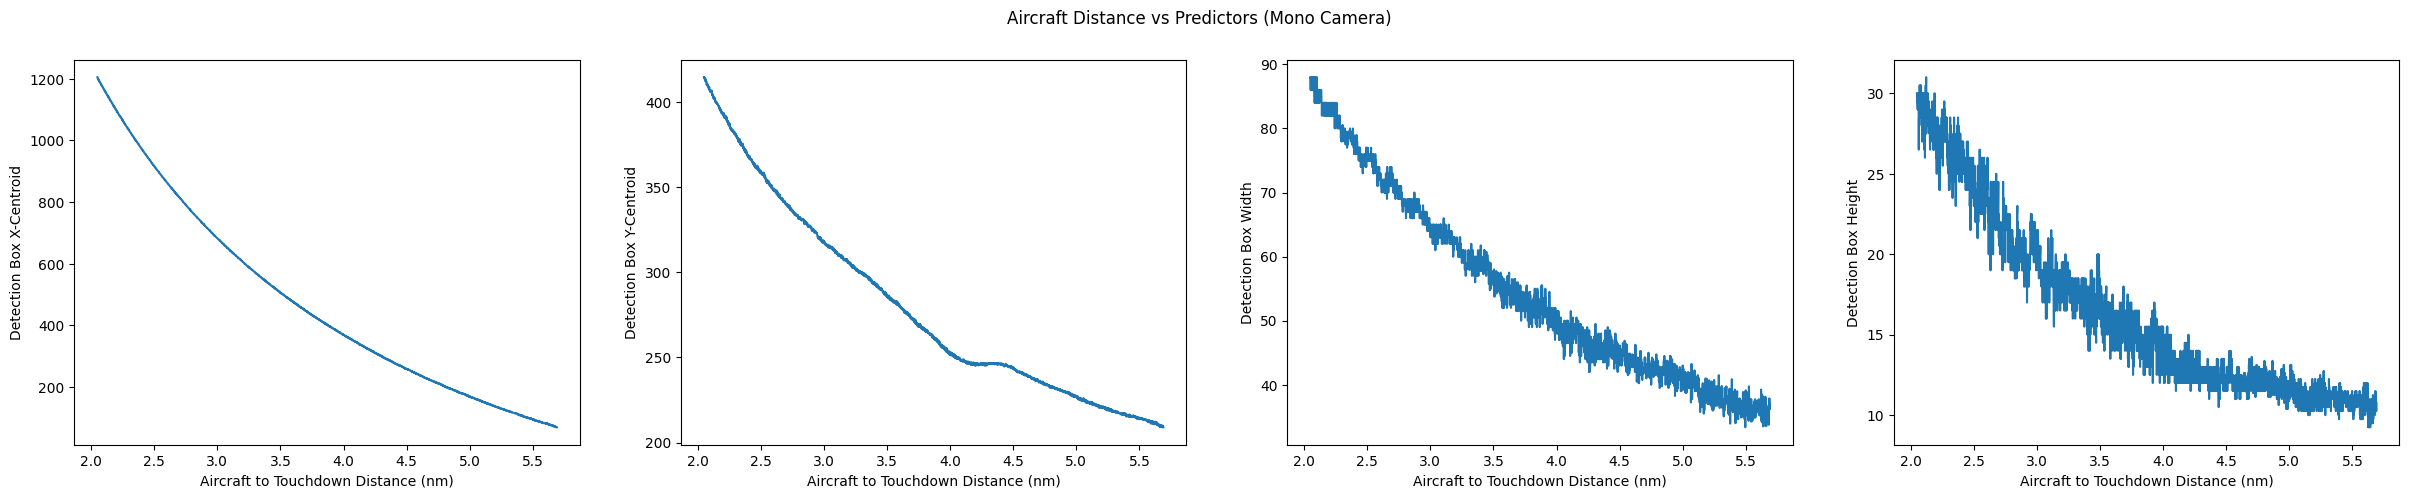

In [6]:
titles = ["Detection Box X-Centroid", "Detection Box Y-Centroid", "Detection Box Width", "Detection Box Height"]
fig, ax = plt.subplots(1,4, figsize=(30,5))
for i in range(0,4):
    ax[i].plot(gt[:-100]*model.scale_gt, pred[:, i][:-100]*model.scale_pred)
    ax[i].set_ylabel(titles[i])
    ax[i].set_xlabel("Aircraft to Touchdown Distance (nm)")
fig.suptitle("Aircraft Distance vs Predictors (Mono Camera)")

In [7]:
x_train, x_test, y_train, y_test = train_test_split(pred[:-100], gt[:-100])
x_train = torch.from_numpy(x_train).to(device).float()
y_train = torch.from_numpy(y_train).to(device).float()
x_test = torch.from_numpy(x_test).to(device).float()
y_test = torch.from_numpy(y_test).to(device).float()

In [20]:
learning_rate = 1e-6
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.0001)

In [21]:
losses = []
epochs = tqdm.tqdm(iterable=range(100000), leave=True)
for epoch in epochs:
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        yt_pred = model(x_test)
        tloss = criterion(yt_pred, y_test)
        losses.append(loss.item())
        display.clear_output(wait=True)
        display.display(epochs.container)
        print("==========================\nEpoch {}".format(epoch))
        print(f'Train loss: {loss.item()}')
        print(f'Test loss : {tloss.item()}')
        print("==========================\n")
        

  1%|          | 980/100000 [00:04<07:36, 216.98it/s]

Epoch 1000
Train loss: 3.602815468184417e-06
Test loss : 3.871989974868484e-06



KeyboardInterrupt: 

In [22]:
torch.save(model, "trained_mlp/wsss_mono_view_2.pt")

In [23]:
model = torch.load("trained_mlp/wsss_mono_view_2.pt")

In [24]:
y = model(torch.from_numpy(pred).float().to(device)).cpu().detach().numpy()

In [25]:
(100 * abs(y[:-100]-gt[:-100])/gt[:-100]).std()

0.24839829427734733

In [26]:
(100 * abs(y[:-100]-gt[:-100])/gt[:-100]).sum()/gt[:-100].shape[0]

0.256201793766897

(0.0, 2.0)

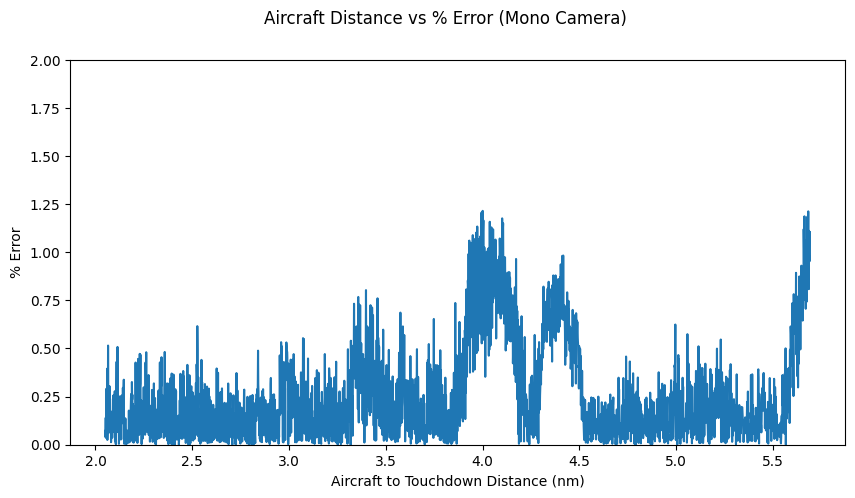

In [27]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
plt.plot(gt[:-100] * model.scale_gt, 100 * abs(y[:-100]-gt[:-100])/gt[:-100])
fig.suptitle("Aircraft Distance vs % Error (Mono Camera)")
ax.set_ylabel("% Error")
ax.set_xlabel("Aircraft to Touchdown Distance (nm)")
ax.set_ylim(0, 2)

# Multi Camera

In [1]:
import torch
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import tqdm.notebook as tqdm
from IPython import display
from sklearn.model_selection import train_test_split
import custom_utils
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True

aircraft-detection custom utils


In [2]:
model = custom_utils.mlp_dual().to(device)

In [3]:
with open('processed_data\\1.pkl', 'rb') as f:
    detections, distances, calibration = pkl.load(f)
pred, gt = custom_utils.convert_to_model_format(detections, distances, calibration, scale_pred = model.scale_pred, scale_gt = model.scale_gt, skip_missing = True)

Text(0.5, 0.98, 'Aircraft Distance vs Predictors (Stereo Camera)')

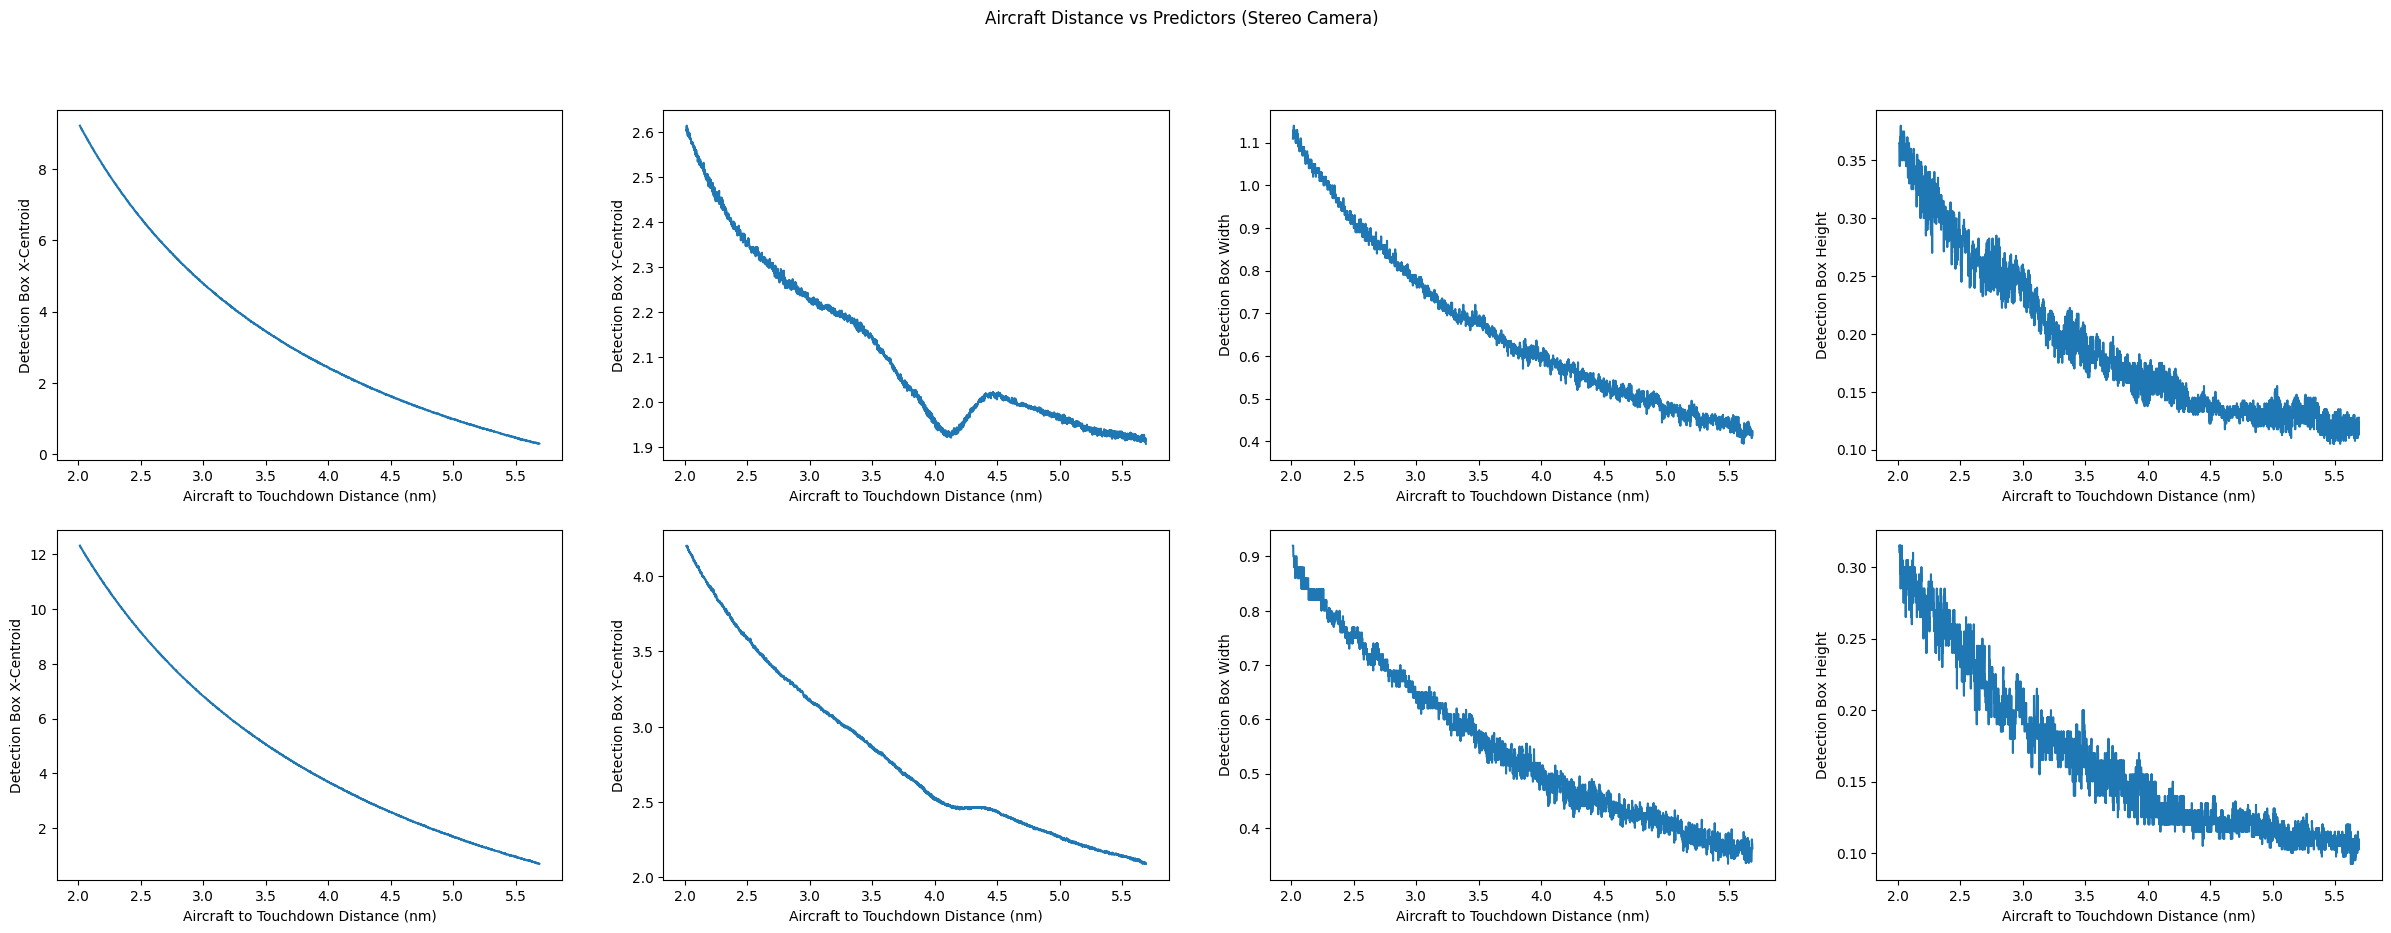

In [4]:
titles = ["Detection Box X-Centroid", "Detection Box Y-Centroid", "Detection Box Width", "Detection Box Height"]
fig, ax = plt.subplots(2,4, figsize=(30,10))
for camera in range(0,2):
    for i in range(0,4):
        ax[camera][i].plot(gt[:-70] * 8, pred[:, camera * 4 + i][:-70])
        ax[camera][i].set_ylabel(titles[i])
        ax[camera][i].set_xlabel(f"Aircraft to Touchdown Distance (nm)")
fig.suptitle("Aircraft Distance vs Predictors (Stereo Camera)")

In [5]:
x_train, x_test, y_train, y_test = train_test_split(pred[:-70], gt[:-70])
x_train = torch.from_numpy(x_train).to(device).float()
y_train = torch.from_numpy(y_train).to(device).float()
x_test = torch.from_numpy(x_test).to(device).float()
y_test = torch.from_numpy(y_test).to(device).float()

In [6]:
losses = []
tlosses = []

In [25]:
learning_rate = 1e-6
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.0001)

In [26]:
model.train()
epochs = tqdm.tqdm(iterable=range(100000), leave=True)
for epoch in epochs:
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        model.eval()
        yt_pred = model(x_test)
        tloss = criterion(yt_pred, y_test)
        tlosses.append(tloss.item())
        losses.append(loss.item())
        display.clear_output(wait=True)
        display.display(epochs.container)
        print("==========================\nEpoch {}".format(epoch))
        print(f'Train loss: {loss.item():.6f}')
        print(f'Test loss : {tloss.item():.6f}')
        print("==========================\n")
        model.train()

  0%|          | 471/100000 [00:01<05:08, 322.55it/s]

Epoch 500
Train loss: 0.000001
Test loss : 0.000001



KeyboardInterrupt: 

In [32]:
torch.save(model, "trained_mlp/wsss_stereo.pt")

In [33]:
model = torch.load("trained_mlp/wsss_stereo.pt")

In [34]:
model.eval()
y = model(torch.from_numpy(pred).to(device).float()).cpu().detach().numpy()

In [35]:
(100 * abs(y[:-70]-gt[:-70])/gt[:-70]).std()

0.11368197861060249

In [36]:
(100 * abs(y[:, 0][:-70]-gt[:, 0][:-70])/gt[:, 0][:-70]).sum()/gt[:-70].shape[0]

0.14007879086735792

In [30]:
gt.shape

(3026, 1)

(0.0, 2.0)

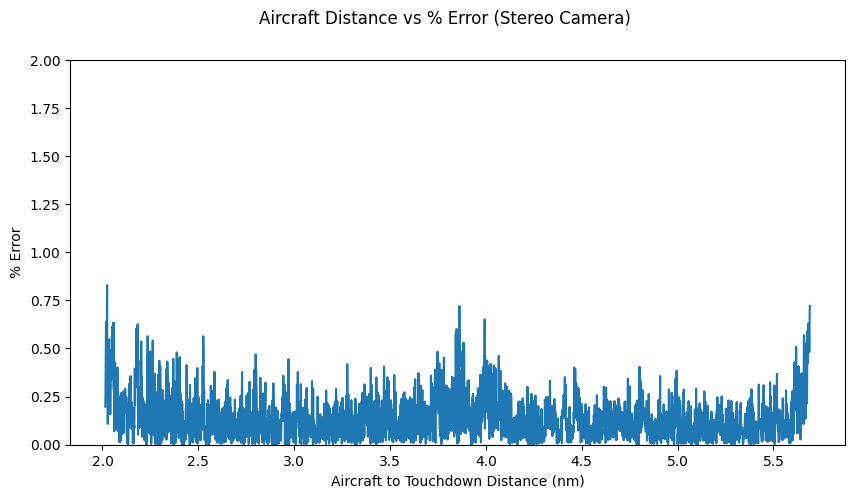

In [31]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(gt[:-70] * model.scale_gt, 100 * abs(y[:-70]-gt[:-70])/gt[:-70])
fig.suptitle("Aircraft Distance vs % Error (Stereo Camera)")
ax.set_ylabel("% Error")
ax.set_xlabel(f"Aircraft to Touchdown Distance (nm)")
ax.set_ylim(0, 2)